In [1]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from collections import defaultdict, Counter
from typing import Tuple
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
from common.utils import draw_chart
import matplotlib.pyplot as plt
import numpy as np
import os

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)

POJISTOVNA = "cpzp"

with open(f"./DATACON_data/{POJISTOVNA}_persons.pkl", "rb") as f:
    persons: list[Person] = pickle.load(f)

In [2]:
data = defaultdict(lambda: {"kortikoid": 0, "imunosupressive": 0})

for person in persons:
    last_prescription_date: datetime = datetime.min.date()
    for presc in person.prescriptions:
        if presc.specializace_lekare is None:
            continue
        if (
            presc.lekova_forma == "Injekční suspenze"
            or presc.lekova_forma == "Injekční/infuzní roztok"
        ):
            if abs((last_prescription_date - presc.date).days) < 14:
                continue
        last_prescription_date = presc.date
        data[presc.specializace_lekare][presc.prescription_type.value] += 1

In [3]:
df = (
    pl.DataFrame(
        [{"specializace_lekare": spec, **counts} for spec, counts in data.items()]
    )
    .with_columns((pl.col("kortikoid") + pl.col("imunosupressive")).alias("total"))
    .filter(pl.col("total") > 100)
    .with_columns(
        (pl.col("kortikoid") / pl.col("total") * 100).alias("kortikoid_pct"),
        (pl.col("imunosupressive") / pl.col("total") * 100).alias(
            "imunosupressive_pct"
        ),
    )
    .sort("total", descending=False)
)

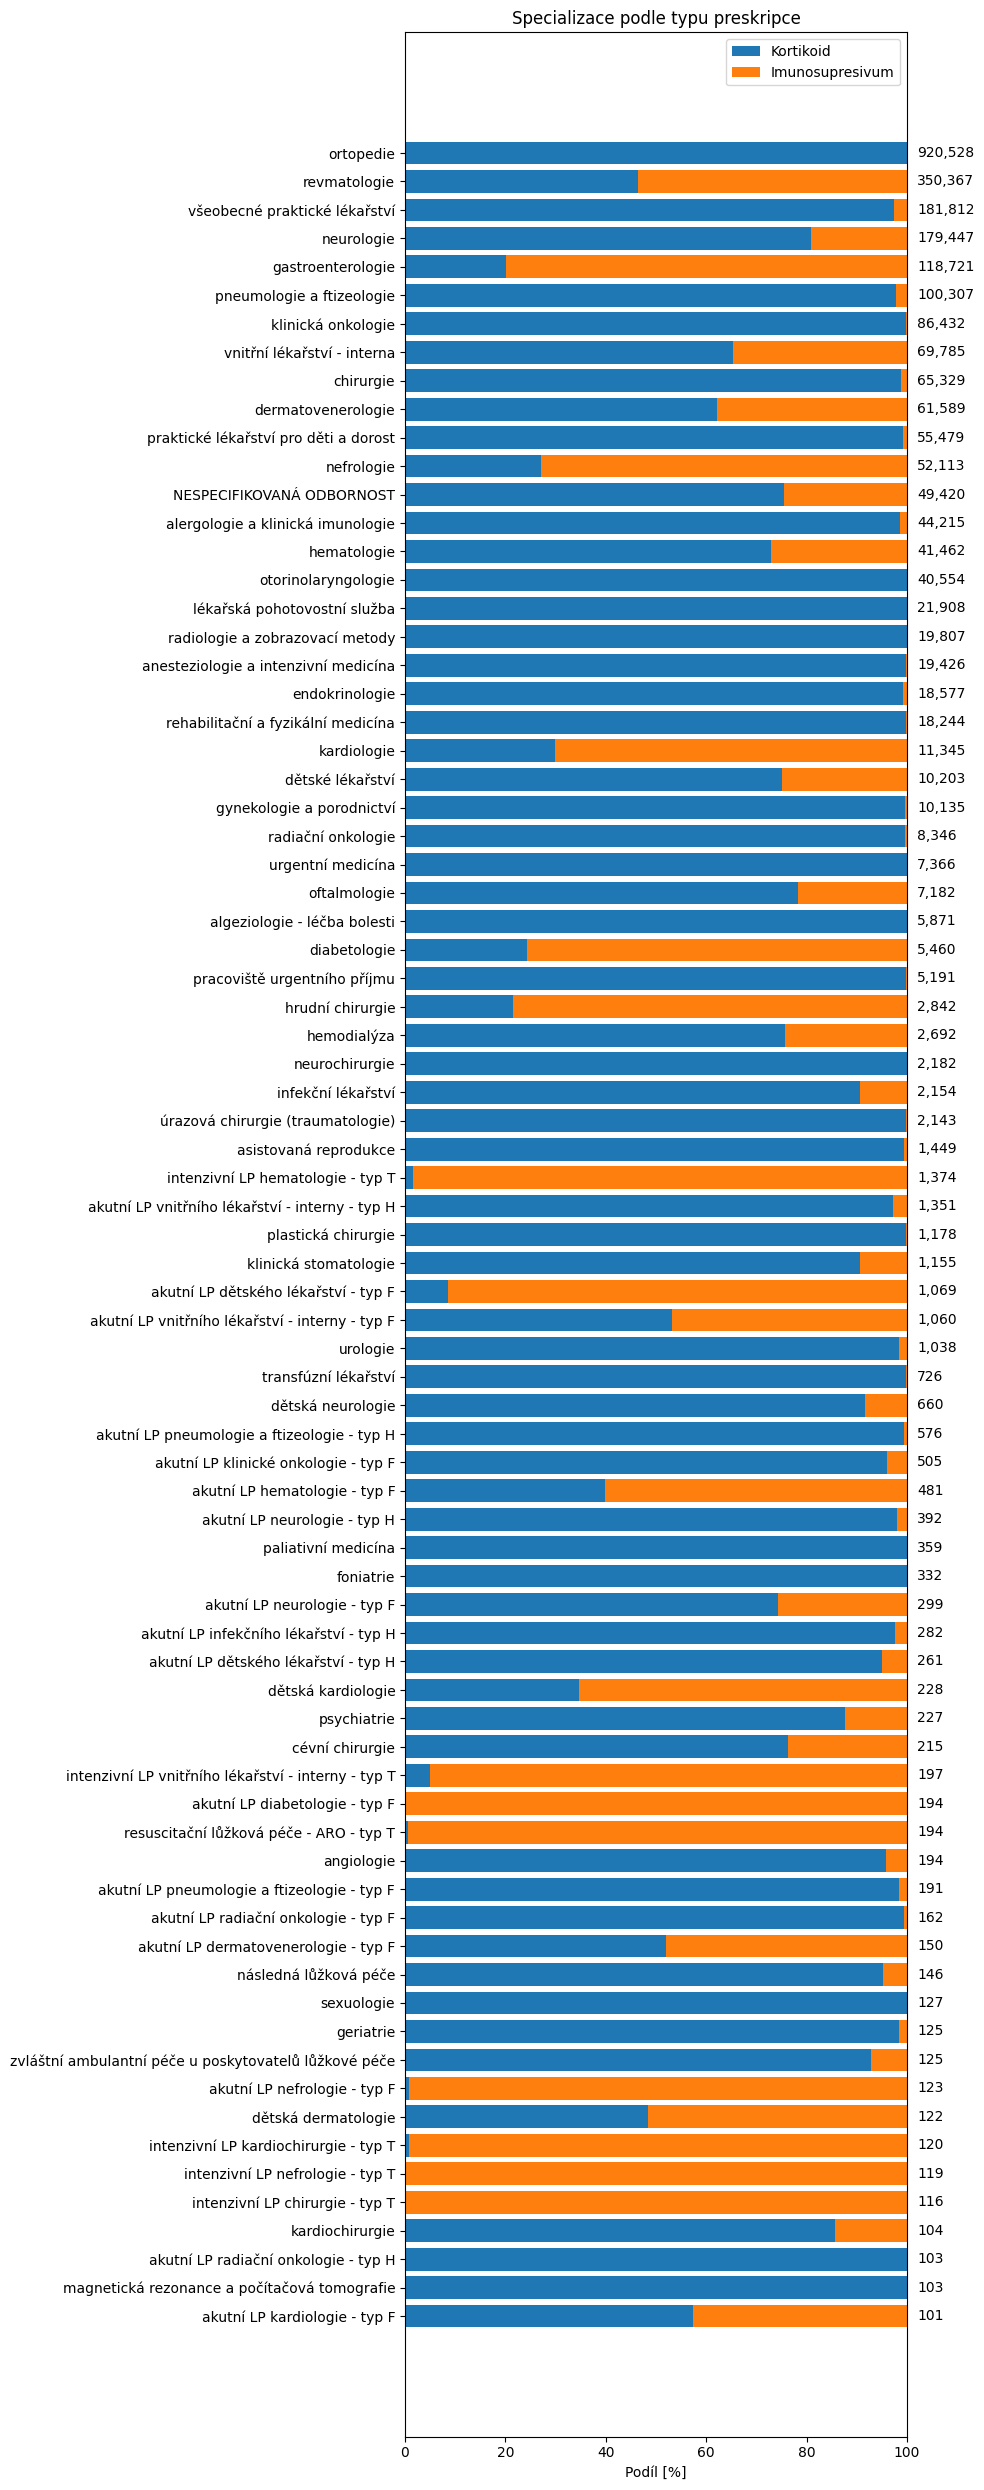

In [4]:
specializations = df["specializace_lekare"].to_list()
kortikoid_pct = df["kortikoid_pct"].to_list()
imunosupressive_pct = df["imunosupressive_pct"].to_list()
total_counts = df["total"].to_list()

fig, ax = plt.subplots(figsize=(10, 25))
y = np.arange(len(specializations))
ax.barh(y, kortikoid_pct, label="Kortikoid")
ax.barh(y, imunosupressive_pct, left=kortikoid_pct, label="Imunosupresivum")

for i, total in enumerate(total_counts):
    ax.text(102, i, f"{total:,}", va="center")

ax.set_yticks(y)
ax.set_yticklabels(specializations)
ax.set_xlabel("Podíl [%]")
ax.set_title("Specializace podle typu preskripce")
ax.legend()
plt.tight_layout()
plt.show()

In [5]:
rows = []
for person in persons:
    for presc in person.prescriptions:
        rows.append(
            {
                "person_id": person.id,
                "date": presc.date,
                "specializace_lekare": presc.specializace_lekare,
            }
        )

first_prescriptions = (
    pl.DataFrame(rows)
    .sort(["person_id", "date"])
    .group_by("person_id")
    .first()  # vezme první řádek v rámci pacienta
)

first_specialization_stats = (
    first_prescriptions.group_by("specializace_lekare")
    .len()
    .sort("len", descending=True)
    .rename({"len": "first_recept_count"})
    .with_columns(
        (pl.col("first_recept_count") / pl.col("first_recept_count").sum() * 100).alias(
            "pct"
        )
    )
)

print(first_specialization_stats)

shape: (154, 3)
┌─────────────────────────────────┬────────────────────┬───────────┐
│ specializace_lekare             ┆ first_recept_count ┆ pct       │
│ ---                             ┆ ---                ┆ ---       │
│ str                             ┆ u32                ┆ f64       │
╞═════════════════════════════════╪════════════════════╪═══════════╡
│ ortopedie                       ┆ 216646             ┆ 43.230289 │
│ všeobecné praktické lékařství   ┆ 41961              ┆ 8.373042  │
│ praktické lékařství pro děti a… ┆ 34045              ┆ 6.793457  │
│ neurologie                      ┆ 30267              ┆ 6.039581  │
│ chirurgie                       ┆ 22306              ┆ 4.451016  │
│ otorinolaryngologie             ┆ 18080              ┆ 3.607745  │
│ revmatologie                    ┆ 17045              ┆ 3.401218  │
│ alergologie a klinická imunolo… ┆ 13728              ┆ 2.739332  │
│ pneumologie a ftizeologie       ┆ 13326              ┆ 2.659116  │
│ lékařská pohotov

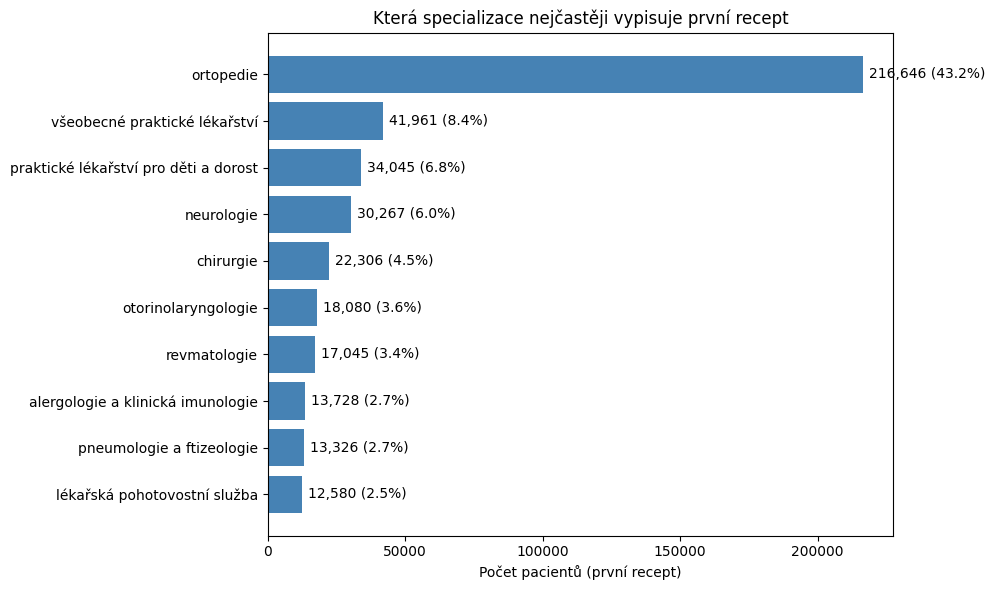

In [6]:
N = 10
df_plot = first_specialization_stats.sort("first_recept_count", descending=True).head(N)

specializations = df_plot["specializace_lekare"].to_list()
counts = df_plot["first_recept_count"].to_list()
pct = df_plot["pct"].to_list()

# Vykreslení
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(len(specializations))
ax.barh(y, counts, color="steelblue")

# Popisky na bary
for i, (val, p) in enumerate(zip(counts, pct)):
    ax.text(val + max(counts) * 0.01, i, f"{val:,} ({p:.1f}%)", va="center")

ax.set_yticks(y)
ax.set_yticklabels(specializations)
ax.invert_yaxis()  # největší nahoře
ax.set_xlabel("Počet pacientů (první recept)")
ax.set_title("Která specializace nejčastěji vypisuje první recept")

plt.tight_layout()
plt.show()